This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### ResNet50 /  Classify 22 Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
#!pip install ipython-autotime

%load_ext autotime

time: 518 µs (started: 2021-12-07 07:10:39 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 2.22 ms (started: 2021-12-07 07:10:39 +00:00)


### Load label data.

In [5]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('label/label_22_emo.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv('label/label_22_emo_valid.csv')
label_train = pd.read_csv('label/label_22_emo_train.csv')
label_test = pd.read_csv('label/label_22_emo_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
       'disgusted'],
      dtype='object')
(19800, 24)
LABELS= ['moved', 'fearful', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 22
TRAIN_DATA_SIZE: 15840
VALID_DATA_SIZE: 1980
TEST_DATA_SIZE: 1980
time: 89.4 ms (started: 2021-12-07 07:10:39 +00:00)


### Calculate class weights.

In [6]:
dict_label_train = {}
for idx, row in label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

15840

time: 3.14 s (started: 2021-12-07 07:10:39 +00:00)


In [7]:
y_train_ls = list(dict_label_train.values())
#y_train_ls

time: 629 µs (started: 2021-12-07 07:10:42 +00:00)


In [8]:
y_train_ints = [y.index(1) for y in y_train_ls]
#y_train_ints

time: 27.3 ms (started: 2021-12-07 07:10:42 +00:00)


In [9]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train_ints),
                                                  y_train_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.88,
 1: 3.2142857142857144,
 2: 0.3314917127071823,
 3: 0.11865524060646011,
 4: 0.9461235216819974,
 5: 3.0,
 6: 5.625,
 7: 0.9809264305177112,
 8: 6.050420168067227,
 9: 12.203389830508474,
 10: 0.46632124352331605,
 11: 0.5286343612334802,
 12: 1.769041769041769,
 13: 32.72727272727273,
 14: 4.444444444444445,
 15: 1.978021978021978,
 16: 2.1114369501466275,
 17: 1.894736842105263,
 18: 5.142857142857143,
 19: 5.853658536585366,
 20: 4.8979591836734695,
 21: 7.741935483870968}

time: 366 ms (started: 2021-12-07 07:10:42 +00:00)


In [10]:
class_weights

array([ 2.88      ,  3.21428571,  0.33149171,  0.11865524,  0.94612352,
        3.        ,  5.625     ,  0.98092643,  6.05042017, 12.20338983,
        0.46632124,  0.52863436,  1.76904177, 32.72727273,  4.44444444,
        1.97802198,  2.11143695,  1.89473684,  5.14285714,  5.85365854,
        4.89795918,  7.74193548])

time: 2.98 ms (started: 2021-12-07 07:10:43 +00:00)


In [11]:
n_samples = len(dict_label_train)
n_classes = len(set(y_train_ints))

time: 3.62 ms (started: 2021-12-07 07:10:43 +00:00)


In [12]:
multiplier = 3
adjusted_cw = class_weights / n_classes * multiplier
adjusted_cw

array([0.39272727, 0.43831169, 0.04520342, 0.01618026, 0.12901684,
       0.40909091, 0.76704545, 0.1337627 , 0.8250573 , 1.66409861,
       0.06358926, 0.0720865 , 0.24123297, 4.46280992, 0.60606061,
       0.26973027, 0.28792322, 0.25837321, 0.7012987 , 0.79822616,
       0.66790353, 1.05571848])

time: 4.45 ms (started: 2021-12-07 07:10:43 +00:00)


In [13]:
log_weights = n_samples / (n_classes * np.log(np.bincount(y_train_ints)))
sum_weights = sum(log_weights)
sum_weights
custom_class_weights = log_weights / sum_weights
custom_class_weights

array([0.04463074, 0.0455364 , 0.03207262, 0.02828986, 0.03714251,
       0.04496317, 0.05078841, 0.03734585, 0.0515632 , 0.06043523,
       0.0335634 , 0.03414671, 0.04101091, 0.07972291, 0.0484368 ,
       0.04178743, 0.04225512, 0.04148481, 0.04986741, 0.05120895,
       0.04937987, 0.05436768])

time: 6.46 ms (started: 2021-12-07 07:10:43 +00:00)


In [14]:
custom_class_weights += adjusted_cw
custom_class_weights

array([0.43735802, 0.48384809, 0.07727604, 0.04447012, 0.16615935,
       0.45405408, 0.81783386, 0.17110854, 0.8766205 , 1.72453384,
       0.09715266, 0.10623322, 0.28224388, 4.54253283, 0.65449741,
       0.3115177 , 0.33017834, 0.29985802, 0.75116611, 0.84943511,
       0.71728339, 1.11008615])

time: 3.72 ms (started: 2021-12-07 07:10:43 +00:00)


In [15]:
class_weight_dict = dict(enumerate(custom_class_weights))
class_weight_dict

{0: 0.43735801571868704,
 1: 0.48384809272560536,
 2: 0.07727603752877807,
 3: 0.04447012394919416,
 4: 0.16615934894029083,
 5: 0.45405407973744055,
 6: 0.8178338647074261,
 7: 0.17110854124487898,
 8: 0.876620496202587,
 9: 1.7245338407756894,
 10: 0.09715266034914719,
 11: 0.10623321618311929,
 12: 0.28224387957200436,
 13: 4.542532828599931,
 14: 0.6544974094004671,
 15: 0.31151769951307157,
 16: 0.3301783420621469,
 17: 0.29985802035019415,
 18: 0.7511661101655956,
 19: 0.8494351130651482,
 20: 0.7172833931995184,
 21: 1.1100861516206217}

time: 4.06 ms (started: 2021-12-07 07:10:43 +00:00)


### Define training pipeline.

In [16]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['./tfrecords/22_emo_train.tfrecords'],
             index_path = ['./tfrecords/22_emo_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 89.5 ms (started: 2021-12-07 07:10:43 +00:00)


### Define validation pipeline.

In [17]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['./tfrecords/22_emo_valid.tfrecords'],
             index_path = ['./tfrecords/22_emo_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.77 ms (started: 2021-12-07 07:10:43 +00:00)


### Train ResNet50 model for classifying 22 emotions.

In [18]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/guides/transfer_learning/

if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)
    
    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 22))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)        

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)     
      
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.softmax        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 22   
        
        base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(64, 64, 3), # VGG16 expects min 32 x 32
            include_top=False, # Do not include the ImageNet classifier at the top.
            pooling='avg') # average pooling added 
        
        base_model.trainable = True   # Unfreeze ResNet50 weights.        
        
        # See how many layers are in the base model.
        print("Number of layers in the base model: ", len(base_model.layers))
        
        # Fine-tune from this layer onwards.
        fine_tune_at = 120
        
        # Freeze all the layers before the `fine_tune_at` layer.
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False    
            
        inputs = keras.Input(shape=(64, 64, 3))
        x = base_model(inputs)
        fc1 = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer)(x)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()
              
        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          callbacks=[es_callback])      

Number of layers in the base model:  176
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 22)                45078     
_________________________________________________________________
dropout (Dropout)            (None, 22)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                506       
Total params: 23,633,296
Trainable params: 17,261,072
Non-trainable params: 6,372,224
_________________________________________________________________
Epoch 1/1000
247/247 [==============================] - 16s 42ms/s

Epoch 50/1000
247/247 [==============================] - 10s 39ms/step - loss: 0.1279 - accuracy: 0.9659 - val_loss: 1.2541 - val_accuracy: 0.7422
Epoch 51/1000
247/247 [==============================] - 10s 39ms/step - loss: 0.1272 - accuracy: 0.9663 - val_loss: 1.3200 - val_accuracy: 0.6943
Epoch 52/1000
247/247 [==============================] - 10s 39ms/step - loss: 0.1132 - accuracy: 0.9699 - val_loss: 1.1401 - val_accuracy: 0.7365
Epoch 53/1000
247/247 [==============================] - 10s 38ms/step - loss: 0.1161 - accuracy: 0.9689 - val_loss: 0.9002 - val_accuracy: 0.7906
Epoch 54/1000
247/247 [==============================] - 10s 39ms/step - loss: 0.1079 - accuracy: 0.9721 - val_loss: 1.1074 - val_accuracy: 0.7589
Epoch 55/1000
247/247 [==============================] - 10s 38ms/step - loss: 0.0936 - accuracy: 0.9734 - val_loss: 0.7179 - val_accuracy: 0.8422
Epoch 56/1000
247/247 [==============================] - 9s 38ms/step - loss: 0.0990 - accuracy: 0.9707 - val_loss: 1.

In [19]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 762 µs (started: 2021-12-07 07:20:03 +00:00)


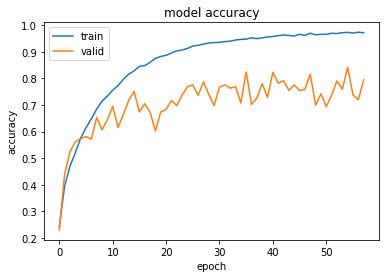

time: 177 ms (started: 2021-12-07 07:20:03 +00:00)


In [20]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

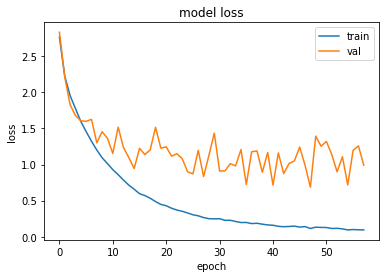

time: 132 ms (started: 2021-12-07 07:20:03 +00:00)


In [21]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [22]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = ['./tfrecords/22_emo_test.tfrecords'],
             index_path = ['./tfrecords/22_emo_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.76 ms (started: 2021-12-07 07:20:03 +00:00)


### Check test data accuracy.

In [23]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset shapes: ((1, 64, 64, 3), (1, 22)), types: (tf.float32, tf.int64)>
1980/1980 [==============================] - 39s 19ms/step - loss: 0.6248 - accuracy: 0.8369
Test accuracy: 0.8368687033653259
A test output from the last layer: [9.7669819e-03 2.9222169e-03 1.3035601e-01 7.4579656e-01 1.6887341e-02
 6.1761108e-03 1.2118698e-02 1.4269519e-02 5.8708899e-04 5.6397100e-04
 4.6801302e-04 3.2359057e-03 1.2025675e-02 6.6783498e-03 7.8768766e-04
 6.6068146e-04 2.3487723e-02 1.1790029e-03 2.2647252e-04 9.0635074e-03
 2.1644398e-03 5.7808653e-04]
Index of the maximum value: 3
Label: angry
time: 39.7 s (started: 2021-12-07 07:20:03 +00:00)


In [24]:
predictions

array([[9.7669819e-03, 2.9222169e-03, 1.3035601e-01, 7.4579656e-01,
        1.6887341e-02, 6.1761108e-03, 1.2118698e-02, 1.4269519e-02,
        5.8708899e-04, 5.6397100e-04, 4.6801302e-04, 3.2359057e-03,
        1.2025675e-02, 6.6783498e-03, 7.8768766e-04, 6.6068146e-04,
        2.3487723e-02, 1.1790029e-03, 2.2647252e-04, 9.0635074e-03,
        2.1644398e-03, 5.7808653e-04],
       [9.7627099e-06, 8.2581073e-06, 1.0031070e-04, 9.9810684e-01,
        2.7093229e-05, 9.7586570e-05, 6.8793941e-04, 3.9918348e-05,
        9.3704130e-06, 7.7606339e-05, 5.1347149e-04, 2.6696956e-05,
        1.8509104e-06, 9.7180986e-05, 1.8169905e-05, 8.5424144e-05,
        7.1843260e-06, 1.4212952e-05, 1.5973865e-05, 6.4745163e-06,
        3.3881784e-05, 1.4838532e-05],
       [5.0432889e-05, 2.3761582e-04, 2.9894193e-06, 4.7102704e-04,
        9.6760118e-01, 2.1489475e-04, 1.2583245e-02, 2.9424191e-03,
        1.0032858e-04, 4.5243371e-07, 1.9383106e-05, 9.2204800e-07,
        4.4973136e-04, 8.6585521e-07, 

time: 4.09 ms (started: 2021-12-07 07:20:43 +00:00)


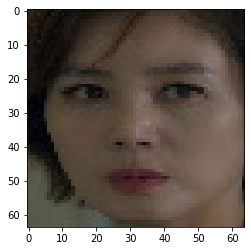

time: 199 ms (started: 2021-12-07 07:20:43 +00:00)


In [25]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [26]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 22), dtype=int64, numpy=array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

time: 2.78 ms (started: 2021-12-07 07:20:43 +00:00)


In [27]:
data

(<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
 array([[[[0.19607843, 0.15686275, 0.10588235],
          [0.18431373, 0.14509805, 0.09411765],
          [0.13725491, 0.10588235, 0.05098039],
          ...,
          [0.07058824, 0.0627451 , 0.05098039],
          [0.10588235, 0.09019608, 0.09019608],
          [0.08235294, 0.06666667, 0.06666667]],
 
         [[0.1764706 , 0.13725491, 0.08627451],
          [0.17254902, 0.13333334, 0.08235294],
          [0.12941177, 0.09803922, 0.04313726],
          ...,
          [0.0627451 , 0.05490196, 0.04313726],
          [0.09411765, 0.07843138, 0.07843138],
          [0.09411765, 0.07843138, 0.07843138]],
 
         [[0.18039216, 0.14901961, 0.09411765],
          [0.15686275, 0.1254902 , 0.07058824],
          [0.1254902 , 0.09019608, 0.04705882],
          ...,
          [0.08627451, 0.07843138, 0.06666667],
          [0.09411765, 0.08627451, 0.08235294],
          [0.07450981, 0.06666667, 0.0627451 ]],
 
         ...,
 
         

time: 8.21 ms (started: 2021-12-07 07:20:43 +00:00)


In [28]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

time: 31.3 s (started: 2021-12-07 07:20:43 +00:00)


In [29]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 773 ms (started: 2021-12-07 07:21:14 +00:00)


In [30]:
true_test.shape

(1980, 22)

time: 2.44 ms (started: 2021-12-07 07:21:15 +00:00)


In [31]:
from sklearn.metrics import confusion_matrix

pred_test_ls = []
true_test_ls = []
for (pred, true) in zip(pred_test, true_test):
    pred_test_ls.append(np.argmax(pred))
    true_test_ls.append(np.argmax(true))

cf_matrix_test = confusion_matrix(true_test_ls, pred_test_ls)
cf_matrix_test

array([[ 25,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  24,   1,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0, 244,  16,   3,   0,   0,   1,   0,   0,   2,   4,   0,
          0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  1,   0,  46, 664,   9,   0,   2,   1,   0,   0,  22,   6,   1,
          0,   1,   3,   0,   2,   0,   0,   0,   1],
       [  2,   0,   5,   8,  72,   0,   0,   0,   0,   0,   3,   1,   0,
          0,   0,   0,   0,   2,   0,   2,   0,   0],
       [  0,   0,   3,   0,   2,  24,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   4,   0,   0,   9,   0,   0,   0,   1,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   7,  10,   0,   0,   0,  63,   0,   0,   4,   2,   0,
          0,   0,   0,   2,   3,   1, 

time: 44.9 ms (started: 2021-12-07 07:21:15 +00:00)


Text(123.0, 0.5, 'True')

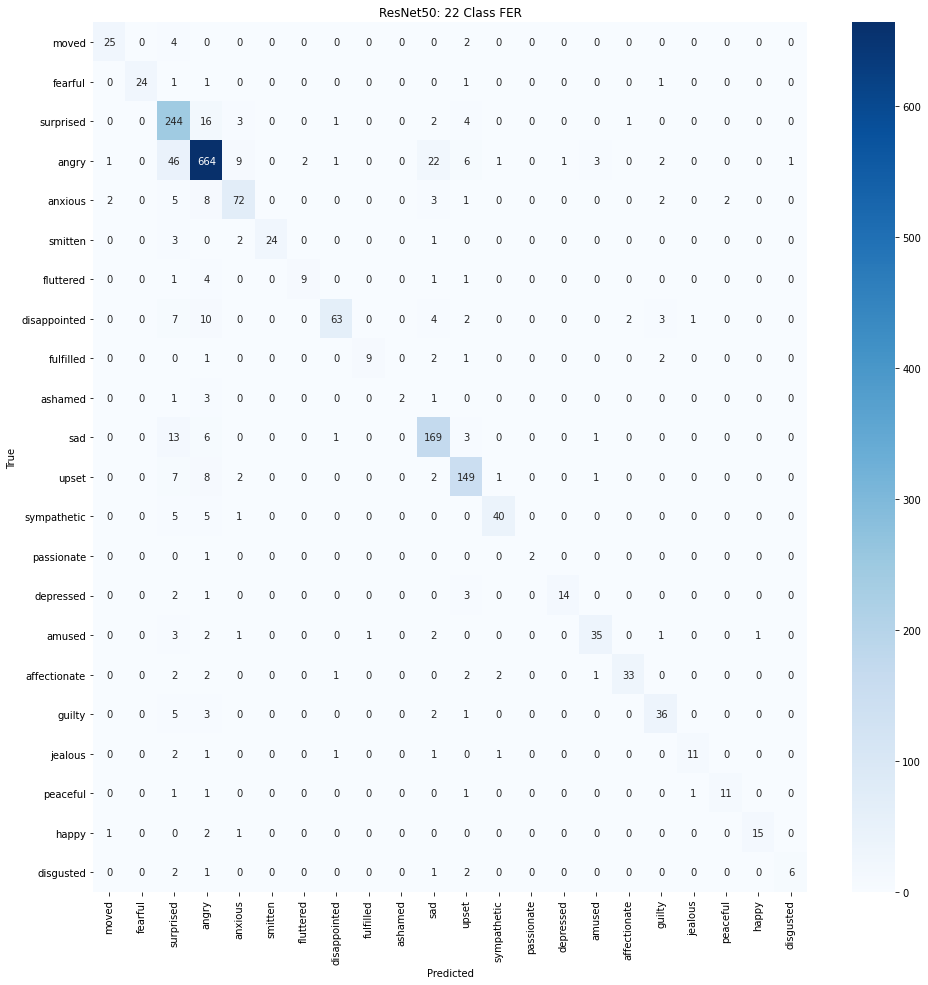

time: 2.3 s (started: 2021-12-07 07:21:15 +00:00)


In [32]:
import seaborn as sns

plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('ResNet50: 22 Class FER')
plt.xlabel('Predicted')
plt.ylabel('True')

### Check train data accuracy.

In [33]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_train, steps=TRAIN_DATA_SIZE)
        print("Train accuracy:", acc)
        #predictions = clf.predict(ds_train.take(1))
        #print("A test output from the last layer:", predictions[0])
        #print("Index of the maximum value:", np.argmax(predictions[0]))
        #print("Label:", LABELS[np.argmax(predictions[0])])

15840/15840 [==============================] - 310s 20ms/step - loss: 0.2591 - accuracy: 0.9242
Train accuracy: 0.9242424368858337
time: 5min 10s (started: 2021-12-07 07:21:18 +00:00)


In [34]:
pred_train = clf.predict(ds_train.take(TRAIN_DATA_SIZE))

time: 4min 7s (started: 2021-12-07 07:26:28 +00:00)


In [35]:
true_train = np.concatenate([y for x, y in ds_train.take(TRAIN_DATA_SIZE)], axis=0)

time: 5.85 s (started: 2021-12-07 07:30:35 +00:00)


In [36]:
true_train.shape

(15840, 22)

time: 2.6 ms (started: 2021-12-07 07:30:41 +00:00)


In [37]:
pred_train_ls = []
true_train_ls = []
for (pred, true) in zip(pred_train, true_train):
    pred_train_ls.append(np.argmax(pred))
    true_train_ls.append(np.argmax(true))

cf_matrix_train = confusion_matrix(true_train_ls, pred_train_ls)
cf_matrix_train

array([[ 218,    0,   10,    5,    0,    1,    0,    1,    0,    0,    4,
          11,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  200,    0,    5,   10,    0,    0,    0,    0,    0,    1,
           4,    0,    0,    0,    1,    0,    2,    0,    1,    0,    0],
       [   0,    0, 2125,   19,    0,    0,    2,    0,    0,    0,   19,
           5,    1,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   2,    0,  152, 5699,   40,    5,    7,    4,    0,    0,  112,
          27,    4,    0,    1,    3,    0,    6,    5,    0,    0,    1],
       [   1,    0,   13,   10,  703,    0,    0,    0,    0,    0,    3,
          12,    3,    0,    0,    1,    0,    8,    0,    7,    0,    0],
       [   0,    0,   25,   16,    0,  196,    0,    0,    0,    0,    2,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1],
       [   0,    0,    6,    5,    5,    0,  107,    2,    0,    0,    2,
           1,    0,    0,    0, 

time: 123 ms (started: 2021-12-07 07:30:41 +00:00)


Text(123.0, 0.5, 'True')

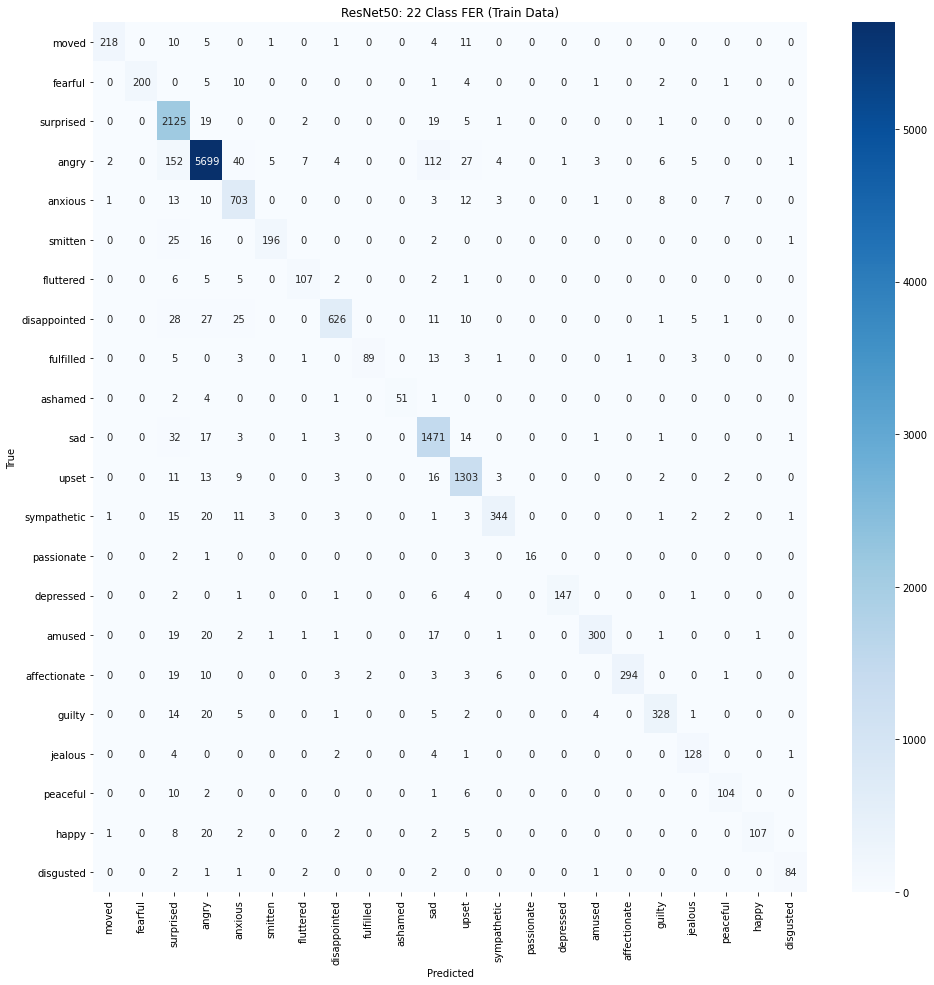

time: 2.42 s (started: 2021-12-07 07:30:41 +00:00)


In [38]:
plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('ResNet50: 22 Class FER (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('True')